<a href="https://colab.research.google.com/github/zzhining/time_series_basic/blob/main/07_forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 데이터 불러오기

In [1]:
!git clone https://github.com/zzhining/time_series_basic.git

Cloning into 'time_series_basic'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 85 (delta 30), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 4.19 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import time_series_basic.util as util

flu_trends = pd.read_csv("./time_series_basic/dataset/flu-trends.csv")
flu_trends.set_index(pd.PeriodIndex(flu_trends.Week, freq="W"), inplace=True)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [4]:
flu_trends.columns

Index(['AInfluenza', 'AcuteBronchitis', 'BodyTemperature', 'BraunThermoscan',
       'BreakAFever', 'Bronchitis', 'ChestCold', 'ColdAndFlu', 'ColdOrFlu',
       'ColdVersusFlu',
       ...
       'TreatingTheFlu', 'TreatmentForFlu', 'TreatmentForTheFlu', 'Tussin',
       'Tussionex', 'TypeAInfluenza', 'UpperRespiratory', 'WalkingPneumonia',
       'WhatToDoIfYouHaveTheFlu', 'FluVisits'],
      dtype='object', length=130)

In [5]:
flu_trends['FluVisits']

,FluVisits
Week,
2009-06-29/2009-07-05,180
2009-07-06/2009-07-12,115
2009-07-13/2009-07-19,132
2009-07-20/2009-07-26,109
2009-07-27/2009-08-02,120
...,...
2016-05-30/2016-06-05,90
2016-06-06/2016-06-12,55
2016-06-13/2016-06-19,33


## 2. 데이터 전처리

다단계 예측 모델을 생성하기 위해 데이터 전처리를 수행합니다. 4주치 지연 속성(lag feature)을 사용하여 8주치 예측값을 도출할 수 있도록 값을 shift합니다.

In [6]:
# 4주치 lag features
y = flu_trends['FluVisits'].copy()
X = util.make_lags(y, lags=4).fillna(0.0)
X.head(10)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0
2009-08-03/2009-08-09,120.0,109.0,132.0,115.0
2009-08-10/2009-08-16,115.0,120.0,109.0,132.0
2009-08-17/2009-08-23,123.0,115.0,120.0,109.0
2009-08-24/2009-08-30,205.0,123.0,115.0,120.0


In [7]:
# 8주치 예측
y = util.make_multistep_target(y, steps=8).dropna()
y.head(10)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0
2009-08-03/2009-08-09,115,123.0,205.0,454.0,628.0,687.0,821.0,1025.0
2009-08-10/2009-08-16,123,205.0,454.0,628.0,687.0,821.0,1025.0,1338.0
2009-08-17/2009-08-23,205,454.0,628.0,687.0,821.0,1025.0,1338.0,1620.0
2009-08-24/2009-08-30,454,628.0,687.0,821.0,1025.0,1338.0,1620.0,2078.0


In [8]:
len(X), len(y)

(366, 359)

X와 y의 길이가 다르므로, 인덱스를 기준으로 공통값이 존재하는 것만 사용합니다.

In [9]:
y, X = y.align(X, join='inner', axis=0)

In [10]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

## 3. 학습 -  Multioutput model

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## 4. 평가 및 예측

In [12]:
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

<Axes: xlabel='Week'>

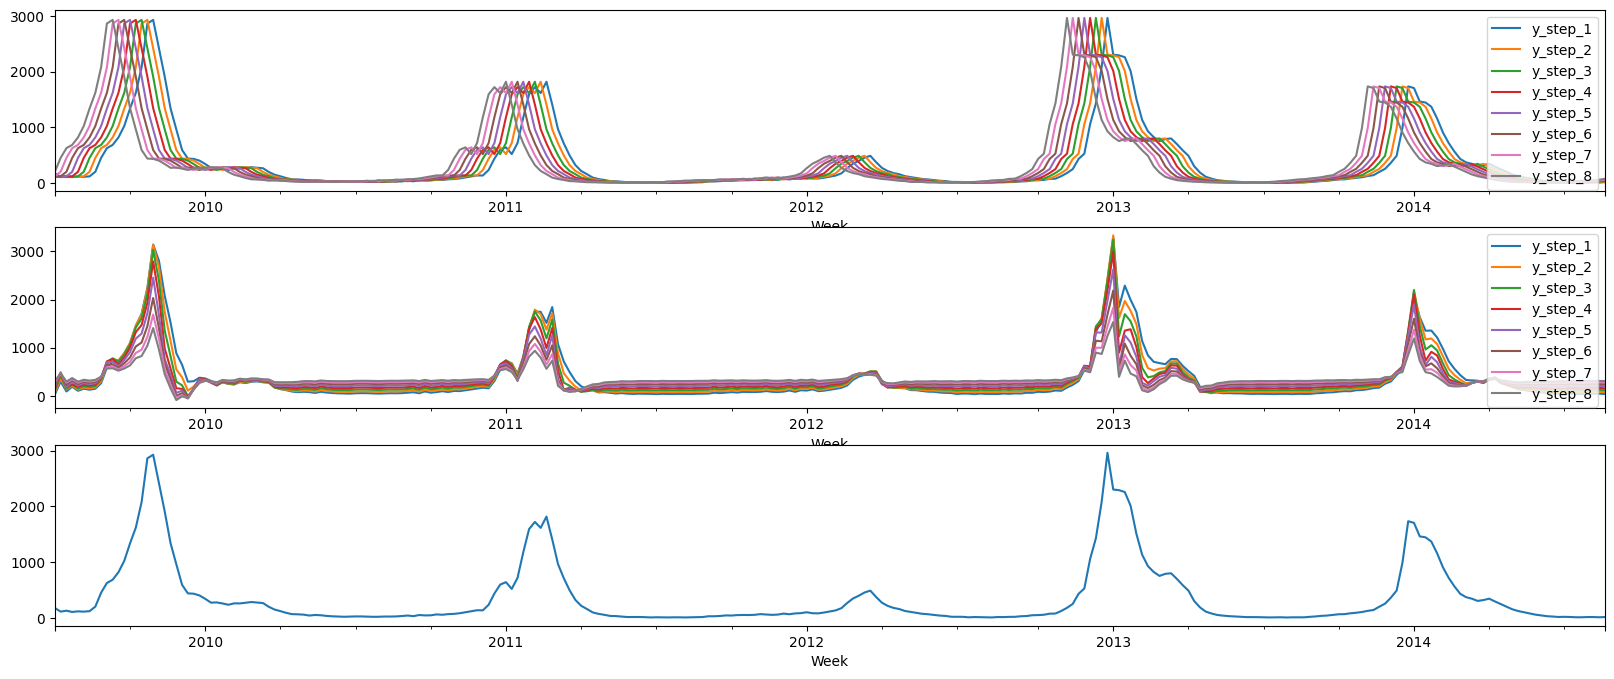

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 8))
y_train.plot(ax=ax1)
y_fit.plot(ax=ax2)
flu_trends['FluVisits'][y_fit.index].plot(ax=ax3)

<Axes: xlabel='Week'>

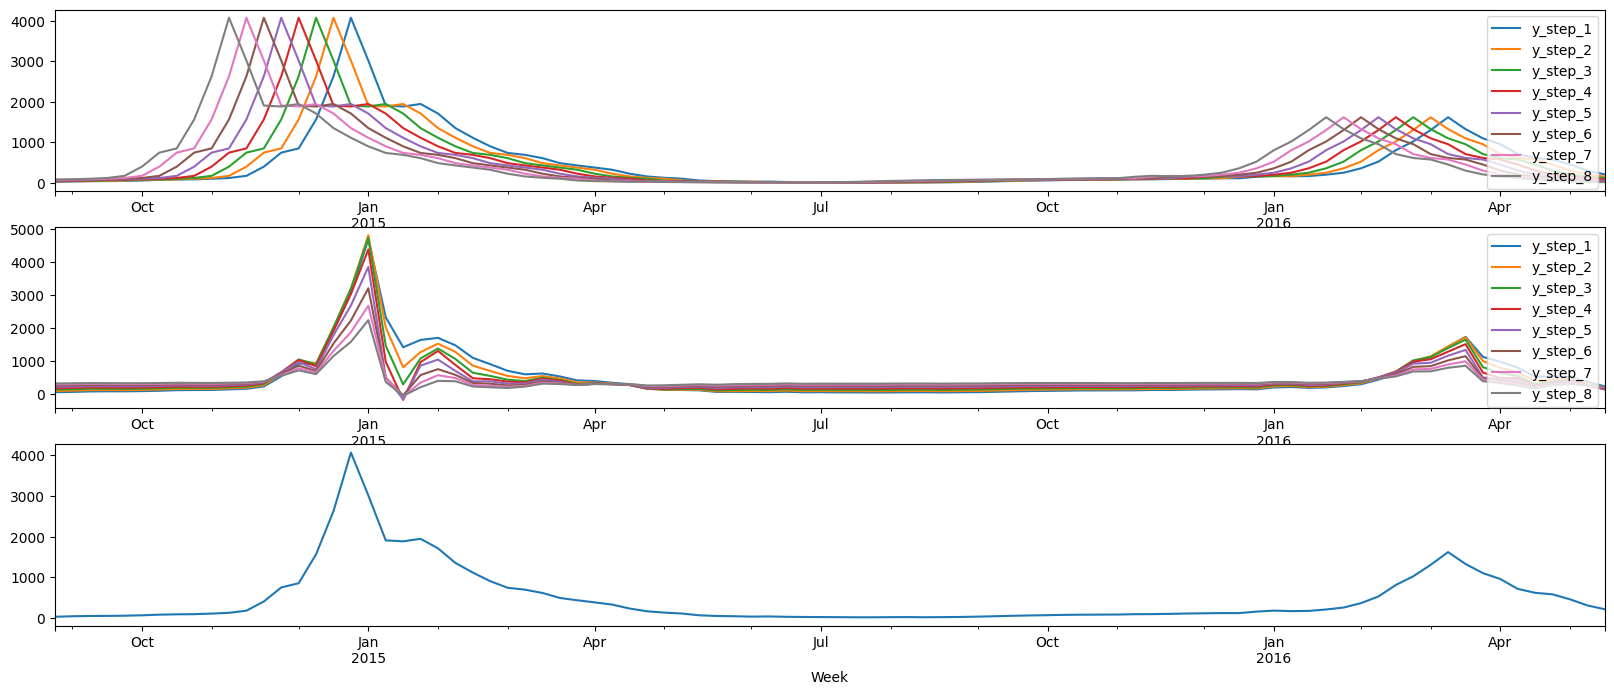

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 8))
y_test.plot(ax=ax1)
y_pred.plot(ax=ax2)
flu_trends['FluVisits'][y_pred.index].plot(ax=ax3)